In [1]:
import numpy as np
import ROOT

Welcome to JupyROOT 6.30/02


In [2]:
def fill_hist_with_sample(hist, sample):
    for val in sample:
        hist.Fill(val)

In [3]:
mc_1 = np.genfromtxt('homework-mc1.csv')
mc_2 = np.genfromtxt('homework-mc2.csv')
data = np.genfromtxt('homework-data.csv')

In [4]:
mc_1_hist = ROOT.TH1F("mc1", "mc1", 60, 0, 600)
fill_hist_with_sample(mc_1_hist, mc_1)
mc_2_hist = ROOT.TH1F("mc2", "mc2", 60, 0, 600)
fill_hist_with_sample(mc_2_hist, mc_2)

mc_1_hist.SetFillColorAlpha(46, 0.35)
mc_2_hist.SetFillColorAlpha(30, 0.35)


mc_stack = ROOT.THStack("mc", "")
mc_stack.Add(mc_1_hist)
mc_stack.Add(mc_2_hist)

data_hist = ROOT.TH1F("data", "data",
                      60, 0, 600)

In [5]:
fill_hist_with_sample(data_hist, data)
 
data_hist.SetMarkerStyle(8)
data_hist.SetMarkerSize(0.5)
data_hist.SetLineColor(1)
data_hist.SetMarkerColor(1)

mc_stack.SetMaximum(1000)

Info in <TCanvas::Print>: png file homework-pre.png has been created


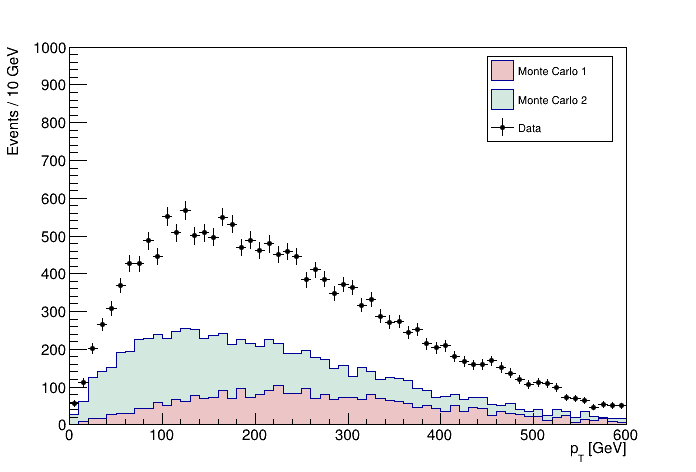

In [6]:
leg = ROOT.TLegend(0.7, 0.7, 0.88, 0.88)
leg.AddEntry(mc_1_hist, "Monte Carlo 1", "f")
leg.AddEntry(mc_2_hist, "Monte Carlo 2", "f")
leg.AddEntry(data_hist, "Data", "lep")


c1 = ROOT.TCanvas("c1", "c1")
mc_stack.Draw('hist')
mc_stack.GetXaxis().SetTitle("p_{T} [GeV]")
mc_stack.GetYaxis().SetTitle("Events / 10 GeV")

data_hist.Draw("p, e0, same")
leg.Draw("same")
c1.Update()
c1.SaveAs("homework-pre.png")

In [7]:
#---------------------------------------------
# start RooFit setup
#---------------------------------------------
pT = ROOT.RooRealVar('pT', 'pT', 0, 600) # define a variable for the stuff
mc1_roo_hist = ROOT.RooDataHist('mc1_roohist', 'mc1_roohist', pT, mc_1_hist)
mc2_roo_hist = ROOT.RooDataHist('mc2_roohist', 'mc2_roohist', pT, mc_2_hist)

data_roo_hist = ROOT.RooDataHist('data_roohist', 'data_roohist', pT, data_hist)

# set constants c1, c2 so that
# (c1*mc1) +  (c2*mc2) = data
c1 = ROOT.RooRealVar('c1', 'c1', 1, 0, 1e30)
c2 = ROOT.RooRealVar('c2', 'c2', 1, 0, 1e30)

In [8]:
#---------------------------------------------
# make model
#---------------------------------------------
# make hist pdfs
mc1_roo_pdf = ROOT.RooHistPdf("mc1_pdf", "mc1_pdf", pT, mc1_roo_hist)
mc2_roo_pdf = ROOT.RooHistPdf("mc2_pdf", "mc2_pdf", pT, mc2_roo_hist)

# make model
model = ROOT.RooAddPdf("model", "model",
                       ROOT.RooArgList(mc1_roo_pdf,
                                       mc2_roo_pdf),
                       ROOT.RooArgList(c1, c2))
# fit
model.fitTo(data_roo_hist)

# because we used PDFs, you gotta recover the real values
# by dividing the constants by nEvents in each MC sample
c1.setVal(c1.getValV() / len(mc_1))
c2.setVal(c2.getValV() / len(mc_2))
print(c1)
print(c2)

RooRealVar::c1 = 4.96926e+08 +/- 0  L(0 - 1e+30) 

RooRealVar::c2 = 2.98156e+08 +/- 0  L(0 - 1e+30) 

[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (mc1_pdf,mc2_pdf)
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(model) WARNING: sum of coefficients is zero 0
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(model) WARNING: sum of coefficients is zero 0
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(model) WARNING: sum of coefficients is zero 0
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(model) WARNING: sum of coefficients is zero 0
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(model) WARNING: sum of coefficients is zero 0
[#

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =   1.907348026e+24 Edm =   1.907349806e+24 NCalls =      9
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 1.907348026e+24
  Edm           : 1.907349806e+24
  Internal parameters:	[     -1.568843202     -1.568843202]	
  Internal gradient  :	[  9.765618792e+26  9.765618792e+26]	
  Internal covariance matrix:
[[  4.0000075e-30              0]
 [              0  4.0000075e-30]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =   1.907348026e+24 Edm =   1.907349806e+24 NCalls =      9
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =    2.98155558e+12 Edm =    2.98366779e+12 NCalls =     14
Warning in <Minuit2>: VariableMetricBuilder No improvement in line search
Info in <Minuit2>: VariableMetricBuilder    2 - FCN =    2.98

Info in <TCanvas::Print>: png file homework-post.png has been created


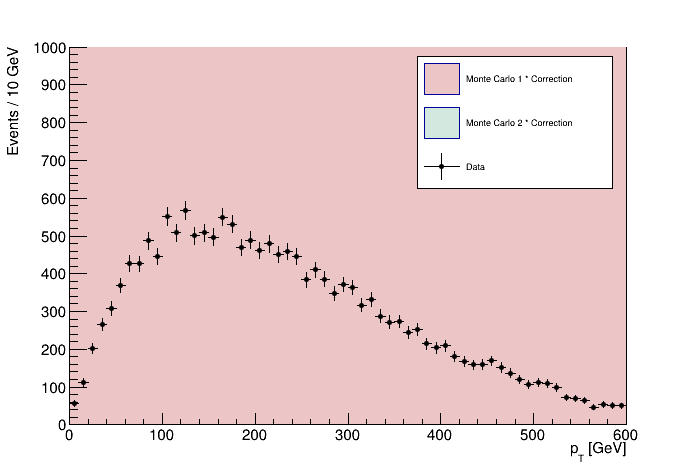

In [9]:
#-----------------------------------------------------
# using corrections, plot new pdf
#-----------------------------------------------------
mc_1_hist_adjusted = mc_1_hist.Clone()
mc_1_hist_adjusted.Scale(c1.getValV())

mc_2_hist_adjusted = mc_2_hist.Clone()
mc_2_hist_adjusted.Scale(c2.getValV())


mc_stack_adjusted = ROOT.THStack("mc_adjusted", "")
mc_stack_adjusted.Add(mc_1_hist_adjusted)
mc_stack_adjusted.Add(mc_2_hist_adjusted)

mc_stack_adjusted.SetMaximum(1000)


leg2 = ROOT.TLegend(0.6, 0.6, 0.88, 0.88)
leg2.AddEntry(mc_1_hist, "Monte Carlo 1 * Correction", "f")
leg2.AddEntry(mc_2_hist, "Monte Carlo 2 * Correction", "f")
leg2.AddEntry(data_hist, "Data", "lep")


c2 = ROOT.TCanvas("c2", "c2")
mc_stack_adjusted.Draw("hist")
mc_stack_adjusted.GetXaxis().SetTitle("p_{T} [GeV]")
mc_stack_adjusted.GetYaxis().SetTitle("Events / 10 GeV")

data_hist.Draw("p, e0, same")
leg2.Draw("same")
c2.Update()
c2.SaveAs("homework-post.png")